In [1]:
from lightning.pytorch import Trainer
import torch
import sys

from joblib import load

sys.path.append("..")

from src.models.nets import FractalNet, CNN_LSTM_Net, LSTM_Net
from src.utils import TimeSeriesDataModule
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

In [2]:
scaler = load('../data/processed/scaler.joblib')

In [3]:
def predict(model, datamodule):
    trainer = Trainer(accelerator='gpu')

    output = trainer.predict(model, dataloaders=datamodule.test_dataloader())
    y_hat = torch.vstack([i[0] for i in output]).flatten()
    y = torch.hstack([i[1] for i in output])

    return (
        scaler.inverse_transform(y.reshape(-1, 1)).flatten(),
        scaler.inverse_transform(y_hat.reshape(-1, 1)).flatten(),
    )

In [4]:
datamodule = TimeSeriesDataModule(
    "../data/processed/global_active_power.csv", "Global_active_power_MinMaxScaler",
    window_size=100
)

../data/processed/global_active_power.csv


In [5]:
fractal_net = FractalNet.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/654041379957559830/1fbf01bafcb44aa48666b77afecd488b/artifacts/model/checkpoints/loss=0.0651/loss=0.0651.ckpt"
)

[block 0] Channel in = 1, Channel out = 128
[block 1] Channel in = 128, Channel out = 256
[block 2] Channel in = 256, Channel out = 256
Last featuremap size = 12
Total layers = 24


In [6]:
fractal_net_2 = FractalNet.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/654041379957559830/052694fda39a47aa87c334c06a5c88eb/artifacts/model/checkpoints/loss=0.0075/loss=0.0075.ckpt"
)

[block 0] Channel in = 1, Channel out = 256
[block 1] Channel in = 256, Channel out = 512
[block 2] Channel in = 512, Channel out = 512
Last featuremap size = 12
Total layers = 24


In [7]:
cnn_lstm = CNN_LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/654041379957559830/a57b16bbec0b4b139077b3a311d0cf5d/artifacts/model/checkpoints/loss=0.0131/loss=0.0131.ckpt"
)

In [8]:
lstm = LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/654041379957559830/823a39dc08c74edf87cdcecbb1ef35d4/artifacts/model/checkpoints/loss=0.0121/loss=0.0121.ckpt"
)

In [9]:
bi_lstm = LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/654041379957559830/468e0b9aebae47fb9ee29aacb851f20d/artifacts/model/checkpoints/loss=0.0097/loss=0.0097.ckpt"
)

In [10]:
y, fractal_pred = predict(fractal_net, datamodule)
y, cnn_lstm_pred = predict(cnn_lstm, datamodule)
y, lstm_pred = predict(lstm, datamodule)
y, bi_lstm_pred = predict(bi_lstm, datamodule)
y, fractal_pred_2 = predict(fractal_net_2, datamodule)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mpry/miniconda3/envs/Dyploma/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RA

Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 81.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 351.06it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 453.95it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 364.40it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 48.90it/s]


In [11]:
eval_results = pl.DataFrame(
    {
        'y_true': y,
        'fractal': fractal_pred,
        'fractal_2': fractal_pred_2,
        'cnn_lstm': cnn_lstm_pred,
        'lstm': lstm_pred,
        'bi_lstm': bi_lstm_pred
    }
)

eval_results

y_true,fractal,fractal_2,cnn_lstm,lstm,bi_lstm
f64,f64,f64,f64,f64,f64
1.0706,1.591792,1.427347,0.969749,1.28042,1.654173
0.3947,0.835865,0.883121,1.109399,1.175524,1.159884
0.4843,0.379208,0.414681,1.087444,0.892948,0.63634
1.5426,0.408492,0.586481,0.718718,0.785341,0.641004
0.793367,1.446051,1.503579,0.557827,1.09491,1.365839
…,…,…,…,…,…
1.7259,1.225401,1.665168,1.283619,1.10621,1.039423
1.573467,1.671938,2.424709,1.478726,1.31441,1.502172
1.659333,1.52183,2.193245,1.780239,1.363961,1.448487


In [12]:
print(eval_results)

shape: (5_089, 6)
┌──────────┬──────────┬───────────┬──────────┬──────────┬──────────┐
│ y_true   ┆ fractal  ┆ fractal_2 ┆ cnn_lstm ┆ lstm     ┆ bi_lstm  │
│ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪═══════════╪══════════╪══════════╪══════════╡
│ 1.0706   ┆ 1.591792 ┆ 1.427347  ┆ 0.969749 ┆ 1.28042  ┆ 1.654173 │
│ 0.3947   ┆ 0.835865 ┆ 0.883121  ┆ 1.109399 ┆ 1.175524 ┆ 1.159884 │
│ 0.4843   ┆ 0.379208 ┆ 0.414681  ┆ 1.087444 ┆ 0.892948 ┆ 0.63634  │
│ 1.5426   ┆ 0.408492 ┆ 0.586481  ┆ 0.718718 ┆ 0.785341 ┆ 0.641004 │
│ 0.793367 ┆ 1.446051 ┆ 1.503579  ┆ 0.557827 ┆ 1.09491  ┆ 1.365839 │
│ …        ┆ …        ┆ …         ┆ …        ┆ …        ┆ …        │
│ 1.7259   ┆ 1.225401 ┆ 1.665168  ┆ 1.283619 ┆ 1.10621  ┆ 1.039423 │
│ 1.573467 ┆ 1.671938 ┆ 2.424709  ┆ 1.478726 ┆ 1.31441  ┆ 1.502172 │
│ 1.659333 ┆ 1.52183  ┆ 2.193245  ┆ 1.780239 ┆ 1.363961 ┆ 1.448487 │
│ 1.1637   ┆ 1.5

In [13]:
import torch
import torchmetrics
import polars as pl

# Перетворюємо стовпці у torch.Tensor
y_true = torch.tensor(eval_results["y_true"].to_list())

# Отримаємо список моделей
model_names = eval_results.columns[
    1:
]  # ["fractal", "fractal_2", "cnn_lstm", "lstm", "bi_lstm"]

# Створюємо словник для зберігання метрик
metrics_dict = {
    "model": [],
    "MSE": [],
    "MAE": [],
    "RMSE": []
}

# Ініціалізуємо метрики
mse_metric = torchmetrics.MeanSquaredError()
mae_metric = torchmetrics.MeanAbsoluteError()

# Обчислюємо метрики для кожної моделі
for model in model_names:
    y_pred = torch.tensor(eval_results[model].to_list())

    mse = mse_metric(y_pred, y_true).item()
    mae = mae_metric(y_pred, y_true).item()
    rmse = torch.sqrt(torch.tensor(mse)).item()  # Обчислюємо RMSE вручну

    metrics_dict["model"].append(model)
    metrics_dict["MSE"].append(mse)
    metrics_dict["MAE"].append(mae)
    metrics_dict["RMSE"].append(rmse)

# Створюємо результуючий Polars DataFrame
df_metrics = pl.DataFrame(metrics_dict)

df_metrics

model,MSE,MAE,RMSE
str,f64,f64,f64
"""fractal""",0.266708,0.3402,0.516438
"""fractal_2""",0.226718,0.338538,0.476149
"""cnn_lstm""",0.352637,0.454437,0.593832
"""lstm""",0.326026,0.434254,0.570987
"""bi_lstm""",0.280318,0.384905,0.52945


In [14]:
sns.set_style('whitegrid')

In [15]:
df = pl.read_csv('../data/processed/global_active_power.csv').filter(pl.col('split_type') == 'test')[100:].with_columns(
    pl.col('date')
        .str
        .to_datetime()
)

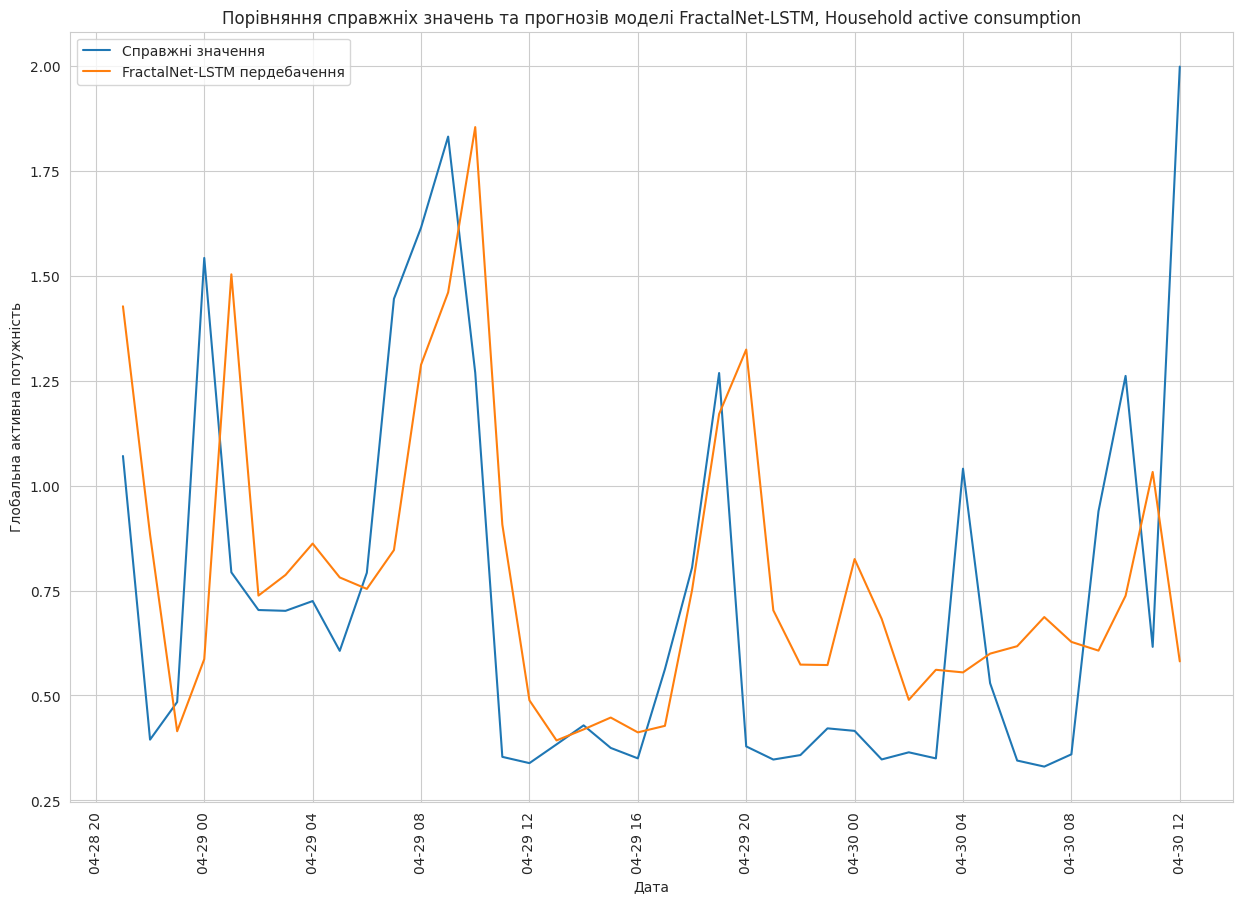

In [16]:
plt.figure(figsize=(15, 10))

sns.lineplot(
    x=df["date"][:40], y=eval_results["y_true"][:40], label="Справжні значення"
)
sns.lineplot(
    x=df["date"][:40], y=eval_results["fractal_2"][:40], label="FractalNet-LSTM пердебачення"
)

plt.title("Порівняння справжніх значень та прогнозів моделі FractalNet-LSTM, Household active consumption")
plt.xticks(rotation=90)

plt.ylabel("Глобальна активна потужність")
plt.xlabel("Дата")

plt.show()